<font size="+3"><strong> Predicting Damage with Decision Trees</strong></font>

# Prepare Data

## Import

In [2]:
import sqlite3
import matplotlib.pyplot as plt
import pandas as pd
from category_encoders import OrdinalEncoder
from IPython.display import VimeoVideo
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.utils.validation import check_is_fitted

In [3]:
def wrangle(db_path):
    # Connect to database
    conn = sqlite3.connect(db_path)

    # Construct query
    query = """
        SELECT distinct(i.building_id) AS b_id,
           s.*,
           d.damage_grade
        FROM id_map AS i
        JOIN building_structure AS s ON i.building_id = s.building_id
        JOIN building_damage AS d ON i.building_id = d.building_id
        WHERE district_id = 4
    """

    # Read query results into DataFrame
    df = pd.read_sql(query, conn, index_col="b_id")

    # Identify leaky columns
    drop_cols = [col for col in df.columns if "post_eq" in col]

    # Add high-cardinality / redundant column
    drop_cols.append("building_id")

    # Create binary target column
    df["damage_grade"] = df["damage_grade"].str[-1].astype(int)
    df["severe_damage"] = (df["damage_grade"] > 3).astype(int)

    # Drop old target
    drop_cols.append("damage_grade")

    # Drop multicollinearity column
    drop_cols.append("count_floors_pre_eq")

    # Drop columns
    df.drop(columns=drop_cols, inplace=True)

    return df

**Task 1:** Use the `wrangle` function above to import your data set into the DataFrame `df`. The path to the SQLite database is `"data/nepal.sqlite"`

In [4]:
df = wrangle("data/nepal.sqlite")
df.head()

,age_building,plinth_area_sq_ft,height_ft_pre_eq,land_surface_condition,foundation_type,roof_type,ground_floor_type,other_floor_type,position,plan_configuration,superstructure,severe_damage
b_id,,,,,,,,,,,,
164002,20,560,18,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,TImber/Bamboo-Mud,Not attached,Rectangular,"Stone, mud mortar",0
164081,21,200,12,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,TImber/Bamboo-Mud,Not attached,Rectangular,"Stone, mud mortar",0
164089,18,315,20,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,TImber/Bamboo-Mud,Not attached,Rectangular,"Stone, mud mortar",0
164098,45,290,13,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,TImber/Bamboo-Mud,Not attached,Rectangular,"Stone, mud mortar",0
164103,21,230,13,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,TImber/Bamboo-Mud,Not attached,Rectangular,"Stone, mud mortar",0


## Split

**Task 2:** Create your feature matrix `X` and target vector `y`. Your target is `"severe_damage"`. 

In [5]:
target = "severe_damage"
X = df.drop(columns="severe_damage")
y = df[target]

**Task 3:** Divide your data (`X` and `y`) into training and test sets using a randomized train-test split. Your test set should be 20% of your total data.


In [6]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)

**Task 4:** Divide your training data (`X_train` and `y_train`) into training and validation sets using a randomized train-test split. Your validation data should be 20% of the remaining data.

In [7]:
X_train, X_val, y_train, y_val = train_test_split(X_train,y_train,test_size=0.2,random_state=42)

# Build Model

## Baseline

**Task 5:** Calculate the baseline accuracy score for your model.

In [8]:
acc_baseline = y_train.value_counts(normalize=True).max()
print("Baseline Accuracy:", round(acc_baseline, 2))

Baseline Accuracy: 0.64


## Iterate

**Task 6:** Create a pipeline named `model` that contains a `OrdinalEncoder` transformer and a `DecisionTreeClassifier` predictor. (Be sure to set a `random_state` for your predictor.) Then fit your model to the training data. 

In [20]:
# Build Model
model = make_pipeline(OrdinalEncoder(),DecisionTreeClassifier( random_state=42))
# Fit model to training data
model.fit(X_train,y_train)

Pipeline(steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['land_surface_condition',
                                      'foundation_type', 'roof_type',
                                      'ground_floor_type', 'other_floor_type',
                                      'position', 'plan_configuration',
                                      'superstructure'],
                                mapping=[{'col': 'land_surface_condition',
                                          'data_type': dtype('O'),
                                          'mapping': Flat              1
Moderate slope    2
Steep slope       3
NaN              -2
dtype: int64},
                                         {'col': 'foundation_type',
                                          'dat...
E-shape                             7
H-shape                             8
Others                              9
Building with Central Courtyard    10
NaN                                -2
dtype: int64},
                                         {'col': 'superstructure',
                                          'data_type': dtype('O'),
                                          'mapping': Stone, mud mortar        1
Stone                    2
RC, engineered           3
Brick, cement mortar     4
Adobe/mud                5
Timber                   6
RC, non-engineered       7
Brick, mud mortar        8
Stone, cement mortar     9
Bamboo                  10
Other                   11
NaN                     -2
dtype: int64}])),
                ('decisiontreeclassifier',
                 DecisionTreeClassifier(random_state=42))])

**Task 7:** Calculate the training and validation accuracy scores for your models. 

In [21]:
acc_train = accuracy_score(y_train,model.predict(X_train))
acc_val = accuracy_score(y_val,model.predict(X_val))

print("Training Accuracy:", round(acc_train, 2))
print("Validation Accuracy:", round(acc_val, 2))

Training Accuracy: 0.98
Validation Accuracy: 0.65


**Task 8:** Use the [`get_depth`] method on the `DecisionTreeClassifier` in your model to see how deep your tree grew during training. 

In [13]:
tree_depth = model.named_steps["decisiontreeclassifier"].get_depth()
print("Tree Depth:", tree_depth)

Tree Depth: 49


**Task 9:** Create a range of possible values for `max_depth` hyperparameter of your model's `DecisionTreeClassifier`. `depth_hyperparams` should range from `1` to `50` by steps of `2`.

In [14]:
depth_hyperparams = range(1,50,2)

**Task 10:** Complete the code below so that it trains a model for every `max_depth` in `depth_hyperparams`. Every time a new model is trained, the code should also calculate the training and validation accuracy scores and append them to the `training_acc` and `validation_acc` lists, respectively. 


In [15]:
# Create empty lists for training and validation accuracy scores
training_acc = []
validation_acc = []

for d in depth_hyperparams:
    # Create model with `max_depth` of `d`
    test_model = make_pipeline(OrdinalEncoder(),DecisionTreeClassifier(max_depth=d,random_state=42))
    # Fit model to training data
    test_model.fit(X_train, y_train)
    # Calculate training accuracy score and append to `training_acc`
    training_acc.append(test_model.score(X_train,y_train))
    # Calculate validation accuracy score and append to `training_acc`
    validation_acc.append(test_model.score(X_val,y_val))

print("Training Accuracy Scores:", training_acc[:3])
print("Validation Accuracy Scores:", validation_acc[:3])

Training Accuracy Scores: [0.7071072484228174, 0.7117395332421582, 0.7162394670666608]
Validation Accuracy Scores: [0.7088406564319746, 0.7132521616375508, 0.7166049055937886]


**Task 11:** Create a visualization with two lines. The first line should plot the `training_acc` values as a function of `depth_hyperparams`, and the second should plot `validation_acc` as a function of `depth_hyperparams`. You x-axis should be labeled `"Max Depth"`, and the y-axis `"Accuracy Score"`. Also include a legend so that your audience can distinguish between the two lines. 

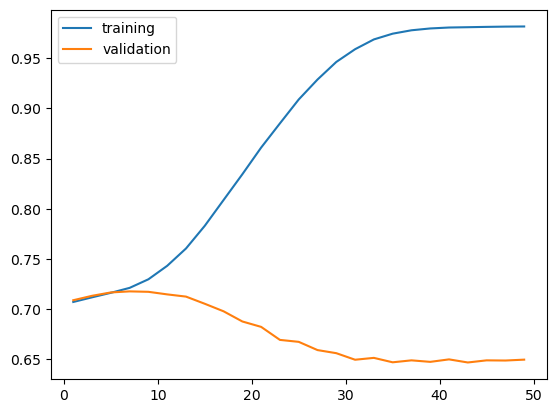

In [16]:
# Plot `depth_hyperparams`, `training_acc`
plt.plot(depth_hyperparams,training_acc,label="training")
plt.plot(depth_hyperparams,validation_acc,label="validation")
plt.legend();

In [22]:
# Build Model
model = make_pipeline(OrdinalEncoder(),DecisionTreeClassifier(max_depth=6, random_state=42))
# Fit model to training data
model.fit(X_train,y_train)

Pipeline(steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['land_surface_condition',
                                      'foundation_type', 'roof_type',
                                      'ground_floor_type', 'other_floor_type',
                                      'position', 'plan_configuration',
                                      'superstructure'],
                                mapping=[{'col': 'land_surface_condition',
                                          'data_type': dtype('O'),
                                          'mapping': Flat              1
Moderate slope    2
Steep slope       3
NaN              -2
dtype: int64},
                                         {'col': 'foundation_type',
                                          'dat...
Others                              9
Building with Central Courtyard    10
NaN                                -2
dtype: int64},
                                         {'col': 'superstructure',
                                          'data_type': dtype('O'),
                                          'mapping': Stone, mud mortar        1
Stone                    2
RC, engineered           3
Brick, cement mortar     4
Adobe/mud                5
Timber                   6
RC, non-engineered       7
Brick, mud mortar        8
Stone, cement mortar     9
Bamboo                  10
Other                   11
NaN                     -2
dtype: int64}])),
                ('decisiontreeclassifier',
                 DecisionTreeClassifier(max_depth=6, random_state=42))])

In [23]:
acc_train = accuracy_score(y_train,model.predict(X_train))
acc_val = accuracy_score(y_val,model.predict(X_val))

print("Training Accuracy:", round(acc_train, 2))
print("Validation Accuracy:", round(acc_val, 2))

Training Accuracy: 0.72
Validation Accuracy: 0.72


## Evaluate


**Task 12:** Based on your visualization, choose the `max_depth` value that leads to the best validation accuracy score. Then retrain your original model with that `max_depth` value. Lastly, check how your tuned model performs on your test set by calculating the test accuracy score below. Were you able to resolve the overfitting problem with this new `max_depth`?

In [24]:
test_acc = model.score(X_test,y_test)
print("Test Accuracy:", round(test_acc, 2))

Test Accuracy: 0.72


# Communicate

**Task 13:** Complete the code below to use the [`plot_tree`] function from scikit-learn to visualize the decision logic of your model. 


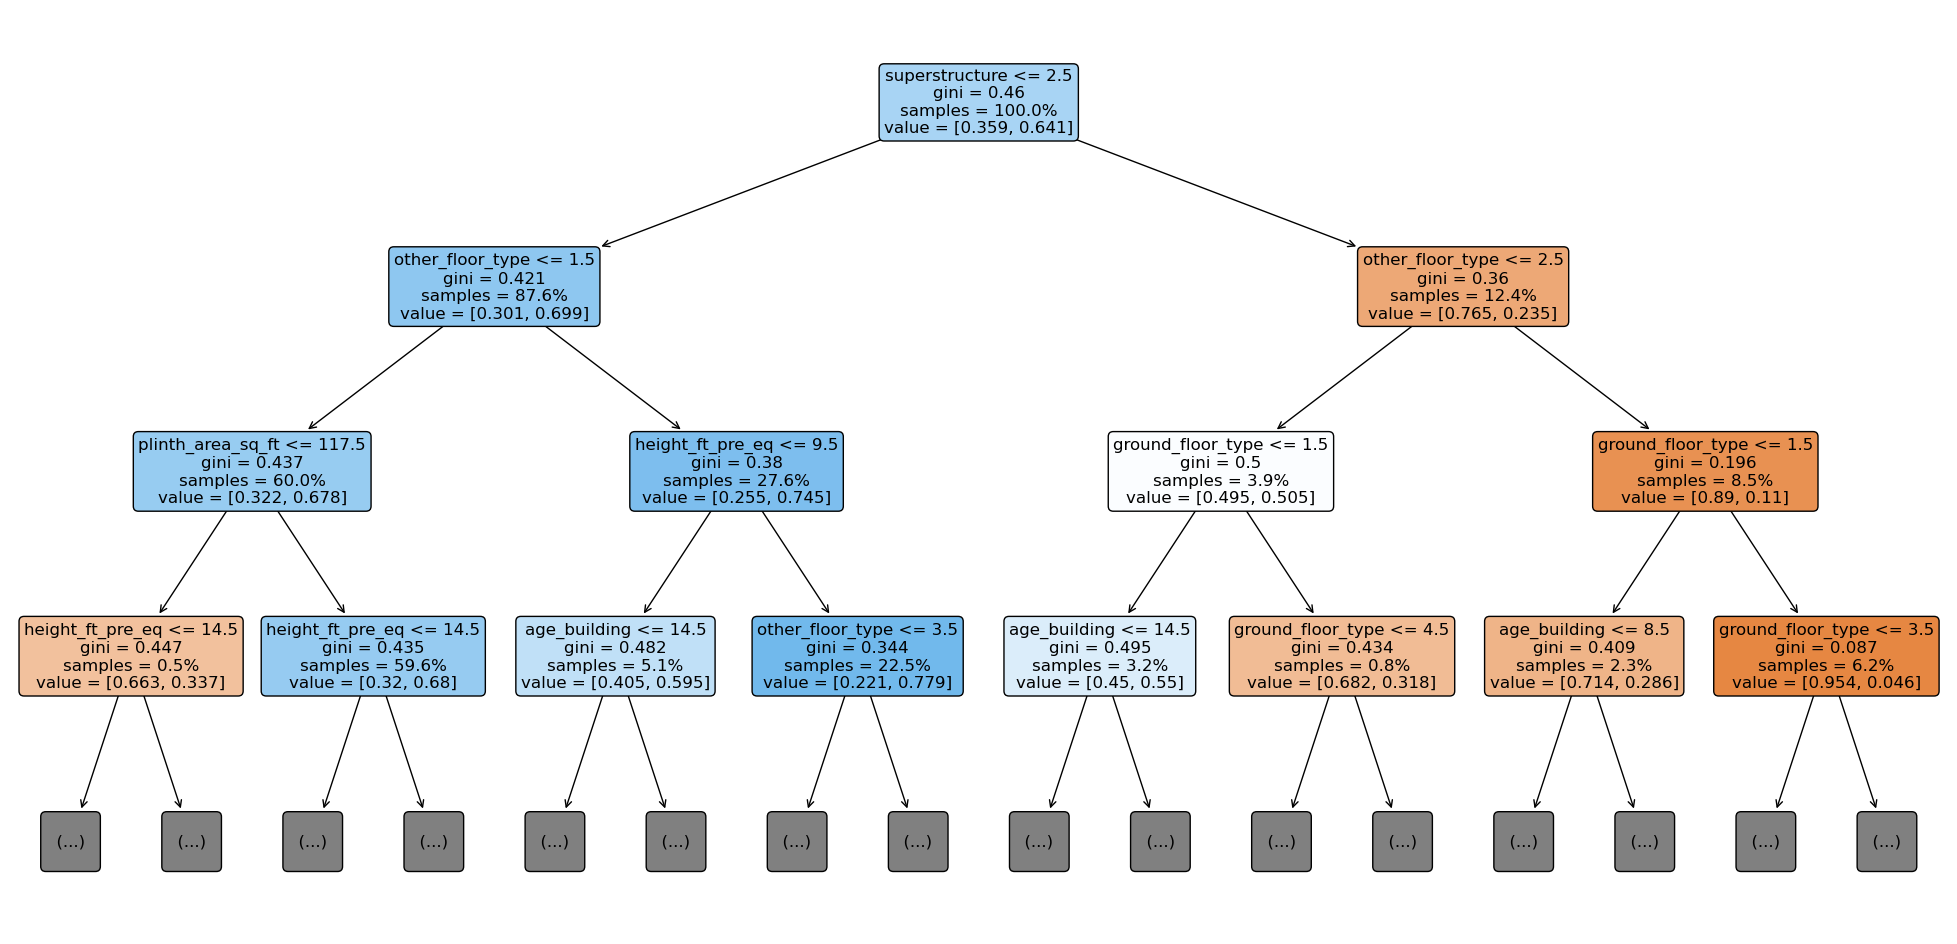

In [25]:
# Create larger figure
fig, ax = plt.subplots(figsize=(25, 12))
# Plot tree
plot_tree(
    decision_tree= model.named_steps["decisiontreeclassifier"],
    feature_names= X_train.columns,
    filled=True,  # Color leaf with class
    rounded=True,  # Round leaf edges
    proportion=True,  # Display proportion of classes in leaf
    max_depth=3,  # Only display first 3 levels
    fontsize=12,  # Enlarge font
    ax=ax,  # Place in figure axis
);

**Task 14:** Assign the feature names and importances of your model to the variables below. For the `features`, you can get them from the column names in your training set. For the `importances`, you access the [`feature_importances_`] attribute of your model's `DecisionTreeClassifier`.

In [26]:
features = X_train.columns
importances = model.named_steps["decisiontreeclassifier"].feature_importances_

print("Features:", features[:3])
print("Importances:", importances[:3])

Features: Index(['age_building', 'plinth_area_sq_ft', 'height_ft_pre_eq'], dtype='object')
Importances: [0.03515085 0.04618639 0.08839161]


**Task 15:** Create a pandas Series named `feat_imp`, where the index is `features` and the values are your `importances`. The Series should be sorted from smallest to largest importance.

In [27]:
feat_imp = pd.Series(importances,index=features).sort_values()
feat_imp.head()

position                  0.000644
plan_configuration        0.004847
foundation_type           0.005206
roof_type                 0.007620
land_surface_condition    0.020759
dtype: float64